In [1]:
'''
Plot model forecast avaibility
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# Define models and variables to plot
models = ['yopp','gfdlsipn']
runType = 'forecast'
variables = ['sic']

In [3]:
def plot_availability(cm):
    f = plt.figure(figsize=(20,4))
    plt.title(E.model[cm.model.item()]['model_label'])
    plt.pcolormesh(cm.fore_time.values.astype('timedelta64[D]').astype('int'), cm.init_time,  cm.data, cmap=cmap )
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Not Available', 'Available'])
    plt.gcf().autofmt_xdate()
    plt.xlabel('Forecast Lead (Days)')
    plt.ylabel('Initialization Date')
    return f

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


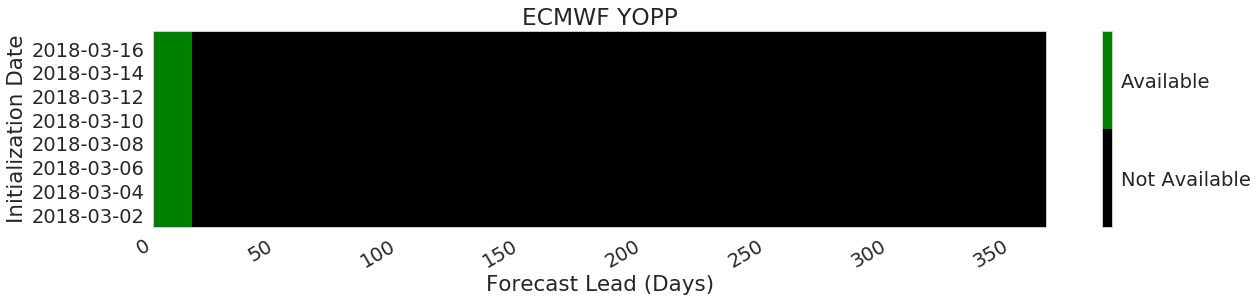

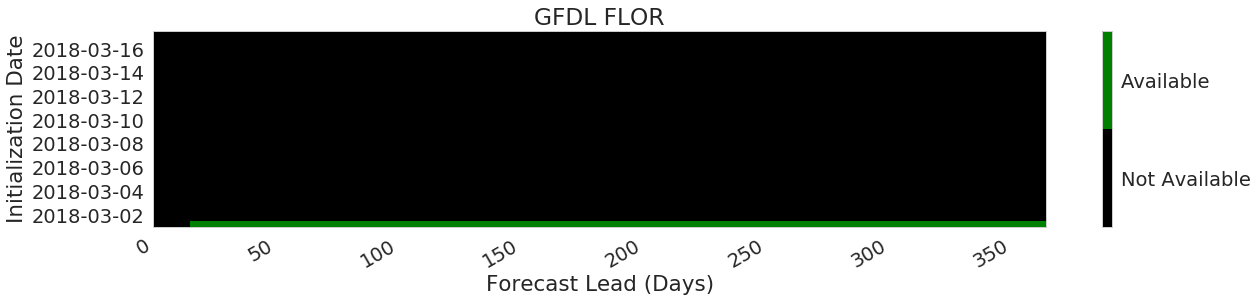

In [4]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

for cvar in variables:

    ds_mm_l = []
    for c_model in models:

        # Load in Model
        model_forecast = os.path.join(E.model[c_model][runType]['sipn_nc'], '*.nc')
        ds_model = xr.open_mfdataset(model_forecast)
        ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

        # Set attributes
        ds_model.attrs['model_label'] = E.model[c_model]['model_label']
        ds_model.attrs['model_grid_file'] = E.model[c_model]['grid']
        ds_model.attrs['stero_grid_file'] = E.obs['NSIDC_0051']['grid']

        # Select var of interest
        ds_model = ds_model[cvar]

        # Average over ensembles (if available)
        ds_model = ds_model.mean(dim='ensemble')

        # Set new dim model
        ds_model.coords['model'] = c_model
        ds_mm_l.append(ds_model)

    # Concat
    ds_mm = xr.concat(ds_mm_l, dim='model')

    #############################################################

    # ds_mm.fore_time.values.astype('timedelta64[D]')

    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # Check if any data for each init/fore time
    da_A = ds_mm.notnull().any(dim='x').any(dim='y').astype('int')

    flatui = ['k', 'g']
    cmap = matplotlib.colors.ListedColormap(sns.color_palette(flatui))

    # Plot
    for c_model in models:
        X = da_A.sel(model=c_model)
        f = plot_availability(X)
        f.savefig(os.path.join(fig_dir,'DataAvailable_'+cvar+'_'+c_model+'.png'),bbox_inches='tight',dpi=200)
        
    # Mem clean up
    ds_mm = None